# Logistic Regression

In [1]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

In [2]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

radiology_dataset_path = '.\\Combined_datas' ### change this

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])



In [4]:
def train_val_dataset(dataset):
    num = np.arange(len(dataset))
    np.random.shuffle(num)
    
    train_idx, test_idx, val_idx =  np.split(num, [int(.8*len(dataset)), int(.9*len(dataset))]) ###len(dataset) didn't work -> 21165
    
    return train_idx, test_idx, val_idx


#train - test - validation split
test_dataset = ImageFolder(radiology_dataset_path, transform= test_transforms)
train_dataset = ImageFolder(radiology_dataset_path, transform= train_transforms)
train_idx, test_idx, val_idx = train_val_dataset(test_dataset)

test_data = Subset(test_dataset, test_idx)
train_data = Subset(train_dataset, train_idx)
val_data = Subset(train_dataset, val_idx)

#loading data
test_loader = DataLoader(test_data, 64, shuffle = True)
train_loader = DataLoader(train_data, 64, shuffle = True)
valid_loader = DataLoader(val_data, 64, shuffle = True)

before transform
actual labels: ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Lung_Opacity']
numerical labels: tensor([0, 3, 1, 1])


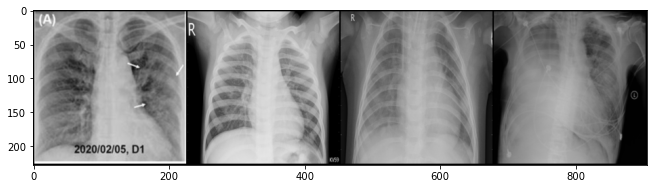

In [8]:
def convert_lab(lab):
    label_dc = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
    return [label_dc[int(i)] for i in list(lab)]

def show_img(data):
    loader = DataLoader(data, 4, shuffle = True)

    batch = next(iter(loader))
    img, lab = batch

    grid = torchvision.utils.make_grid(img, nrow=4)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    print(f'actual labels: {convert_lab(lab)}')
    print(f'numerical labels: {lab}')

###################################
print('before transform')
show_img(ImageFolder(radiology_dataset_path, transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
train data
actual labels: ['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']
numerical labels: tensor([1, 3, 0, 2])


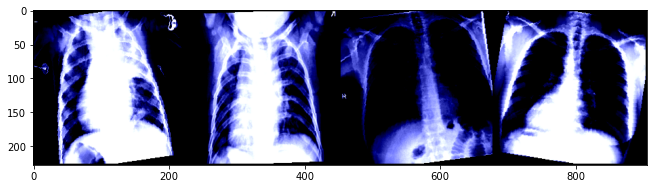

In [9]:
print('train data')
show_img(train_data)

In [15]:
from helper_evaluation import compute_accuracy
from helper_train import train_model

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [16]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(224*224*3, 4)
        
    def forward(self, x):
        logits = self.linear(x.view(-1, 3*224*224))
        probas = F.sigmoid(logits)
        return probas

In [17]:
torch.manual_seed(RANDOM_SEED)

model = LogisticRegression(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0265 | Loss: 1.3991
Epoch: 001/010 | Batch 0050/0265 | Loss: 1.1858
Epoch: 001/010 | Batch 0100/0265 | Loss: 1.2195
Epoch: 001/010 | Batch 0150/0265 | Loss: 1.1949
Epoch: 001/010 | Batch 0200/0265 | Loss: 1.1628
Epoch: 001/010 | Batch 0250/0265 | Loss: 1.1137
Epoch: 001/010 | Train: 55.91% | Validation: 58.29%
Time elapsed: 2.10 min
Epoch: 002/010 | Batch 0000/0265 | Loss: 1.2102
Epoch: 002/010 | Batch 0050/0265 | Loss: 1.1278
Epoch: 002/010 | Batch 0100/0265 | Loss: 1.0807
Epoch: 002/010 | Batch 0150/0265 | Loss: 1.1211
Epoch: 002/010 | Batch 0200/0265 | Loss: 1.1353
Epoch: 002/010 | Batch 0250/0265 | Loss: 1.1674
Epoch: 002/010 | Train: 34.76% | Validation: 35.29%
Time elapsed: 4.16 min
Epoch: 003/010 | Batch 0000/0265 | Loss: 1.2211
Epoch: 003/010 | Batch 0050/0265 | Loss: 1.2843
Epoch: 003/010 | Batch 0100/0265 | Loss: 1.1585
Epoch: 003/010 | Batch 0150/0265 | Loss: 1.1112
Epoch: 003/010 | Batch 0200/0265 | Loss: 1.2396
Epoch: 003/010 | Batch 0250/0265 |

# Evaluation (Logistic Regression)

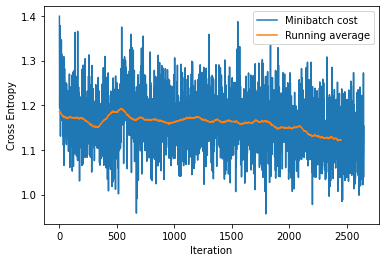

In [18]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

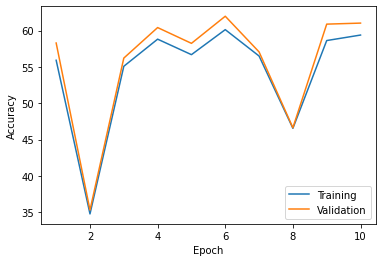

In [19]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 61.22%
Validation ACC: 61.22%
Test ACC: 60.92%
